In [1]:
import matplotlib.pyplot as plt
import numpy as np
#import stan
import pandas as pd
from scipy import stats
from scipy.special import softmax
from datetime import datetime
import time
import pickle 
#import json
from scipy.stats import dirichlet, beta

In [2]:
list(np.ones(10))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [3]:
def cumulative(a,b):
    if len(a) != len(b): 
        print('Lengths do not match')
        return
    out = []
    for i in range(len(a)):
        out.append(np.dot(a[:i+1],b[:i+1]))
    return out

def cumulative2(a,b):
    if len(a) != len(b): 
        print('Lengths do not match')
        return
    out = []
    for i in range(len(a)):
        out.append(sum(a[:i+1]) + sum(b[:i+1]))
    return out

#### Original

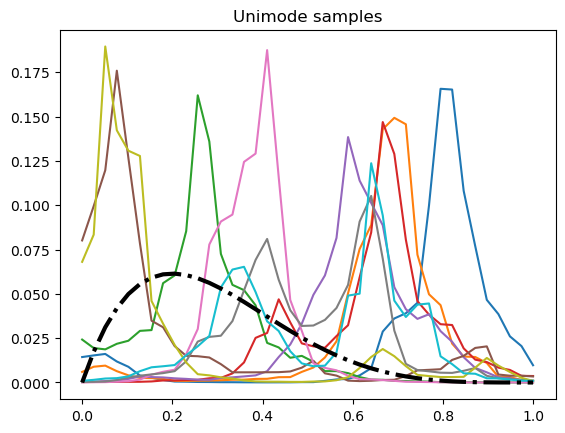

In [22]:
K=40 # number of bins
x = np.linspace(0,1,K)
alpha0 = beta.pdf(x,2,5) # something like a prior, but thatis not necessarily used
for l in range(10):      # we'll plot l curves
    #w = dirichlet.rvs([0.05]*K)[0]
    #alpha = [0.05/K]*K 
    #alpha = [0.5/K]*K 
    alpha = [0.01] * K      # these are going to be the Dirichlet parameters
    w = dirichlet.rvs(alpha)[0]    # Weights for summing many curves, each with the mode in each bien.  The alpha parameters control the w distribution!
    a = abs(np.random.normal(0,0.5,K-1))   # Sample K-1 half normals that will be the step difference of the function from each bin to the next one
    p0 = [0]*K   # A 0-vector of length K
    
    for k in range(K):                        # We loop on k
        sign = [-1]*(K-1)                     # create a vector with -1's up to k
        if k>0:                               # and then +1 up to the end, K
            sign[:k-1] = [1]*(k-1)            # e.g. for k=4 and K=10: [+1,+1,+1,+1,-1,-1,-1,-1,-1,-1]
        logp = [0] + cumulative(sign,a)       # Study the cummulative function above: logp = [0, a1, a1+a2, a1+a2+a3, a1+a2+a3+a4, a1+a2+a3+a4-a5, a1+a2+a3+a4-a5-a6,....]
        t = softmax(logp) * w[k]              # softmax it to sum to 1, and then give it a weight as sampled from Dirichlet above
        p0 = [sum(x) for x in zip(p0, t)]     # sums two vectors element-wise, p0 starts as 0, but then comes another k and p0 gets updated including all the instances of the modes at each bin, and weighted by the w's
    plt.plot(x,p0)
plt.plot(x,[x/K for x in alpha0],'-.',color='black',linewidth=3)
plt.title('Unimode samples')
plt.show()

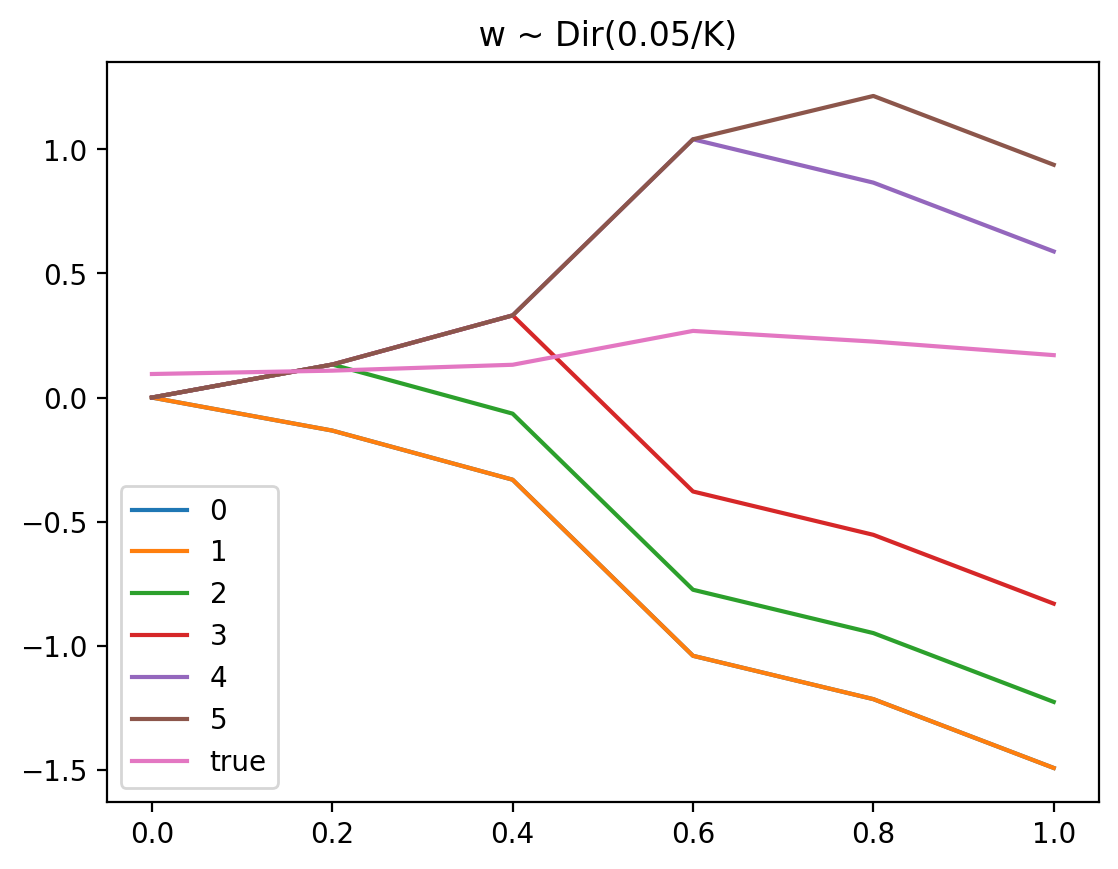

[8.60778397e-072 2.31347257e-006 4.51482363e-053 1.82443191e-134
 9.99997687e-001 5.33138568e-023]


In [6]:
K=6
plt.figure(dpi=200)
x = np.linspace(0,1,K)
alpha0 = beta.pdf(x,2,5)
for l in range(1):
    #w = dirichlet.rvs([0.05]*K)[0]
    alpha = [0.05/K]*K 
    #alpha = [0.1] * K    
    w = dirichlet.rvs(alpha)[0]
    a = abs(np.random.normal(0,0.5,K-1))
    p0 = [0]*K
    
    for k in range(K):
        sign = [-1]*(K-1)
        if k>0:
            sign[:k-1] = [1]*(k-1)
        logp = [0] + cumulative(sign,a)
        t = softmax(logp) * w[k]
        plt.plot(x,logp, label=str(k))
        p0 = [sum(x) for x in zip(p0, t)]   # sums two vectors element-se 
    plt.plot(x,p0, label='true')
#plt.plot(x,[x/K for x in alpha0],'-.',color='black',linewidth=3)
plt.title(' w ~ Dir(0.05/K)')
plt.legend()
plt.show()
print(w)

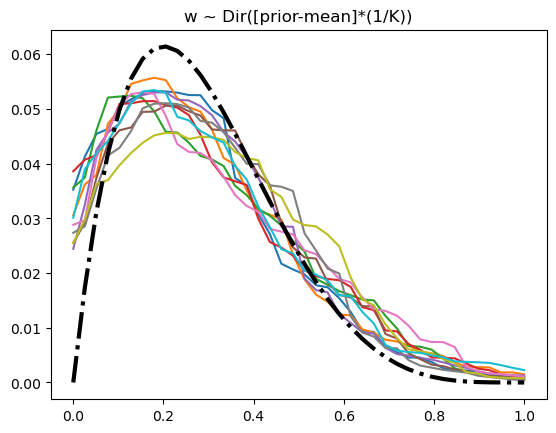

In [11]:
K=40
x = np.linspace(0,1,K)
alpha0 = beta.pdf(x,2,5)
#plt.plot(x,beta.pdf(x,2,5))
alpha = [(10)*x0+0.001 for x0 in alpha0]
for l in range(10):
    #w = dirichlet.rvs([0.05]*K)[0]
    w = dirichlet.rvs(alpha)[0]
    a = abs(np.random.normal(0,0.23,K-1))
    p0 = [0]*K
    
    for k in range(K):
        sign = [-1]*(K-1)
        if k>0:
            sign[:k-1] = [1]*(k-1)
        logp = [0] + cumulative(sign,a)
        t = softmax(logp) * w[k]
        p0 = [sum(x) for x in zip(p0, t)]    
    plt.plot(x, p0)
plt.plot(x,[x/K for x in alpha0],'-.',color='black',linewidth=3)
plt.title('w ~ Dir([prior-mean]*(1/K))')
plt.show()

#### Gaussian Process

In [201]:
prior_distribution = [x, [xx/K for xx in beta.pdf(x,2,5)]]
log_prior_distribution = np.log(prior_distribution)

/tmp/ipykernel_736018/3271320781.py:2: RuntimeWarning: divide by zero encountered in log
  log_prior_distribution = np.log(prior_distribution)


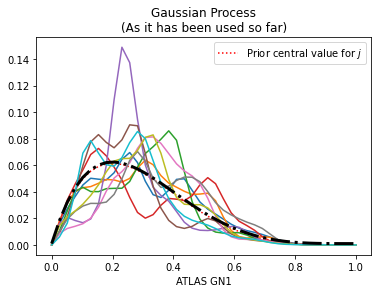

In [264]:
Cov = np.eye(K)
priors0 = []
priors1 = []
#correlation = 9.9
#sigma = 1
for jj in range(10):
    sigma = 0.25
    correlation = 3.5
    for i in range(K-1):
        for j in range(K-1):
            Cov[i][j] =  sigma * np.exp( - pow(abs(i-j)/(correlation),2));
    priors0.append(np.random.multivariate_normal(log_prior_distribution[1], Cov, size=1))
plt.plot(prior_distribution[0], prior_distribution[1], ':r', label='Prior central value for $j$')
for i in range(len(priors0)):
        plt.plot(prior_distribution[0],  softmax(priors0[i])[0], '-') 

plt.plot(x,alpha,'-.',color='black',linewidth=3)
plt.legend()
plt.xlabel('ATLAS GN1')
#plt.yticks([])
#plt.ylim(0,0.4)
plt.title('Gaussian Process\n(As it has been used so far)')

plt.show()            

#### Beta variation to Yulings

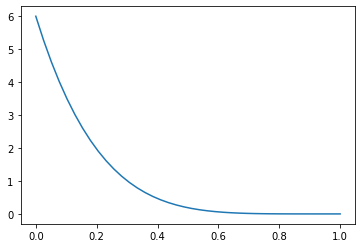

In [208]:
plt.plot(x,beta.pdf(x,1,6))
plt.show()

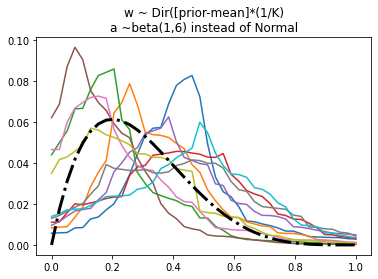

In [249]:
K=40
x = np.linspace(0,1,K)
alpha0 = beta.pdf(x,2,5)
#plt.plot(x,beta.pdf(x,2,5))
alpha = [(1/K)*x+0.001 for x in alpha0]
for l in range(10):
    #w = dirichlet.rvs([0.05]*K)[0]
    w = dirichlet.rvs(alpha)[0]
    a = beta.rvs(1,6,size=K-1)
    p0 = [0]*K
    
    for k in range(K):
        sign = [-1]*(K-1)
        if k>0:
            sign[:k-1] = [1]*(k-1)
        logp = [0] + cumulative(sign,a)
        t = softmax(logp) * w[k]
        p0 = [sum(x) for x in zip(p0, t)]    
    plt.plot(x, p0)
plt.plot(x,[x/K for x in alpha0],'-.',color='black',linewidth=3)
plt.title('w ~ Dir([prior-mean]*(1/K)\na ~ beta(1,6) instead of Normal')
plt.show()


#### My own unimodal


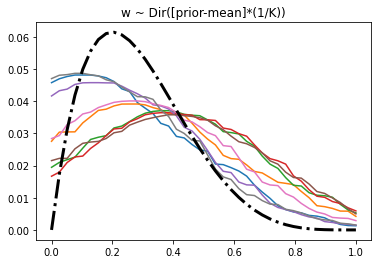

In [81]:
K=40
x = np.linspace(0,1,K)
alpha0 = beta.pdf(x,2,5)
tot = sum(alpha0)
p = [x/tot for x in alpha0]
#plt.plot(x,beta.pdf(x,2,5))
alpha = [(1/K)*x+0.001 for x in alpha0]
for l in range(8):
    mode = np.random.choice([x for x in range(len(alpha))], size=1, p = p)[0]
    #a = abs(np.random.normal(0,0.2,K))
    a = np.random.uniform(0,1,K)
    sign = [-1]*(K)
    sign[:mode] = [1]*mode
    handle = [(abs(i-mode))**1/(2*K) for i in range(K)]
    handle[mode:] = [-handle[mode+i] for i in range(K-mode)]
    logp = cumulative(handle,a)
    t = softmax(logp)
    plt.plot(x, t)
    #plt.plot(x, logp)
plt.plot(x,[x/K for x in alpha0],'-.',color='black',linewidth=3)
plt.title('w ~ Dir([prior-mean]*(1/K))')
plt.show()

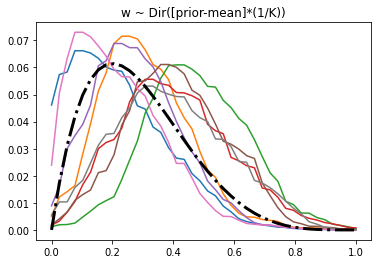

In [87]:
K=40
x = np.linspace(0,1,K)
alpha0 = beta.pdf(x,2,5)
tot = sum(alpha0)
p = [x/tot for x in alpha0]
#plt.plot(x,beta.pdf(x,2,5))
alpha = [(1/K)*x+0.001 for x in alpha0]
for l in range(8):
    mode = np.random.choice([x for x in range(len(alpha))], size=1, p = p)[0]
    #a = abs(np.random.normal(0,0.2,K))
    a = np.random.uniform(0,1,K)
    sign = [-1]*(K)
    sign[:mode] = [1]*mode
    handle = [(abs(i-mode)/(mode))**1 for i in range(K)]
    handle[mode:] = [-(abs(i-mode)/(K-mode))**1 for i in range(mode, K)]
    logp = cumulative(handle,a)
    t = softmax(logp)
    plt.plot(x, t)
    #plt.plot(x, logp)
plt.plot(x,[x/K for x in alpha0],'-.',color='black',linewidth=3)
plt.title('w ~ Dir([prior-mean]*(1/K))')
plt.show()

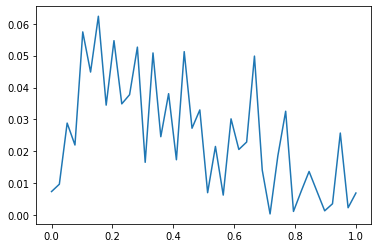

In [74]:
plt.plot(x,dirichlet.rvs(1+alpha0)[0])
plt.show()

In [73]:
alpha0

array([0.00000000e+00, 6.93318208e-01, 1.24633592e+00, 1.67544231e+00,
       1.99586144e+00, 2.22169221e+00, 2.36594819e+00, 2.44059756e+00,
       2.45660302e+00, 2.42396167e+00, 2.35174490e+00, 2.24813833e+00,
       2.12048167e+00, 1.97530864e+00, 1.81838688e+00, 1.65475783e+00,
       1.48877664e+00, 1.32415207e+00, 1.16398639e+00, 1.01081529e+00,
       8.66647760e-01, 7.33006009e-01, 6.10965358e-01, 5.01194142e-01,
       4.03993612e-01, 3.19337831e-01, 2.46913580e-01, 1.86160256e-01,
       1.36309772e-01, 9.64264587e-02, 6.54469651e-02, 4.22201587e-02,
       2.55470265e-02, 1.42205751e-02, 7.06573189e-03, 2.97924507e-03,
       9.69584668e-04, 1.96842978e-04, 1.26351911e-05, 0.00000000e+00])

#### Bologna's talk

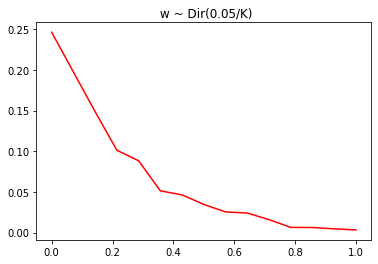

In [40]:
K=15
x = np.linspace(0,1,K)
alpha0 = beta.pdf(x,2,5)
for l in range(1):
    #w = dirichlet.rvs([0.05]*K)[0]
    alpha = [0.05/K]*K 
    #alpha = [0.1] * K    
    w = dirichlet.rvs(alpha)[0]
    a = abs(np.random.normal(0,0.5,K-1))
    p0 = [0]*K
    
    for k in range(1,K):
        sign = [-1]*(K-1)
        if k>0:
            sign[:k-1] = [1]*(k-1)
        logp = [0] + cumulative(sign,a)
        logp0 = [0] + cumulative(sign,[1]*(K-1)) 
        #if l == 0: 
        #    plt.plot(logp0)
        #    plt.title(k)
        #    plt.show()
        #    plt.plot(logp0)
        #    plt.plot(logp)
        #    plt.title(k)
        #    plt.show()
        #    plt.title(k)
        #    plt.plot(softmax(logp0))
        #    plt.show()
        #    plt.plot(softmax(logp0))
        #    plt.plot(softmax(logp))
        #    plt.title(k)
        #    plt.show()
            
        t = softmax(logp) * w[k]
        p0 = [sum(x) for x in zip(p0, t)]   # sums two vectors element-se 
    plt.plot(x,p0, 'r')
#plt.plot(x,[x/K for x in alpha0],'-.',color='black',linewidth=3)
plt.title(' w ~ Dir(0.05/K)')
#plt.savefig('uni5.png')
plt.show()